# Detecting blurry images with a CNN
This notebook contains code to classify images as sharp or blurry, based on an convolutional neural network (CNN) that was trained on a dataset that contains both sharp and blurry images, as preprocessed in the PreProcessing1.ipynb notebook (from the MR4 set).

A CNN is implemented with Keras with a TensorFlow backend.

The rationale behind using a CNN is that certain filters (kernels) can be used to detect blur. By training the CNN, the network will (most likely) generate filters work like this. An example of such a filter is a LaPlacian[1]

The end of the notebook contains some examples of predicted and wrongly predicted images.

[1] https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/

In [1]:

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import cv2 as cv
import glob
import math
import datetime
import random
import matplotlib.pyplot as plt

# To make it reproducible :-)
random.seed(21)
tf.set_random_seed(20)

# Tested on tensorflow version 1.5.0
print(tf.__version__)

%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)

1.5.0


# Settings

In [2]:
INPUT_DIM = 200            # input dimension of images in pixels (assumes a square image)
NUM_OF_CATEGORIES = 1     # total number of categories

INPUT_FOLDER = '../../processed_multiblur/'
ORIG_FOLDER = 'orig/'
BLUR_FOLDER = 'blur/'
TEST_SPLIT_FRAC = 0.2

FIT_BATCH_SIZE = 128
FIT_MAX_EPOCHS = 60
FIT_VALIDATION_SPLIT = 0.2

FIT_STOP_MIN_DELTA = 0.01
FIT_STOP_PATIENCE = 2


MODEL_STRUCTURE = [
    keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same', input_shape=(INPUT_DIM,INPUT_DIM,3)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'),
    keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'),
#     keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
#     keras.layers.Conv2D(32, kernel_size=3, activation='relu', padding='same'),
#     keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'),
    keras.layers.Flatten(),
    keras.layers.Dense(100),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(100),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(NUM_OF_CATEGORIES, activation='sigmoid'),
]

# Create test/train set

In [3]:
dir_content = glob.glob(INPUT_FOLDER+ORIG_FOLDER+'*.jpg')
input_filenames = [x.split('/')[-1] for x in dir_content]

In [4]:
# Every filenames appears twice: once in blur and once in orig
# We split the set of filenames into a training and a test set
# Please note: a filename appears twice: once in blur and once in orig

num_test_items = math.floor( len(input_filenames) * TEST_SPLIT_FRAC )
print('Selecting {} test items from total set {}'.format(num_test_items,len(input_filenames)))

random.shuffle(input_filenames)

test_items = input_filenames[:num_test_items]
train_items = input_filenames[num_test_items:]



Selecting 224 test items from total set 1123


# Loading train & test images into memory

In [5]:
def load_images(items, orig_folder, blur_folder):
    y = []
    x = []

    for file in items:
        orig = cv.imread(orig_folder+file)
        blur = cv.imread(blur_folder+file)

        x.append(orig)
        y.append(1) # original sample = positive = 1

        x.append(blur)
        y.append(0) # blurred sample = negative = 0

    # Randomize the set (otherwise it will always be 10101010101010)
    zipped = list(zip(x,y))
    random.shuffle(zipped)
    x,y = zip(*zipped)
    
    x_set = np.stack(x, axis=0)
    
    return x_set, np.asarray(y)


orig_folder = INPUT_FOLDER+ORIG_FOLDER
blur_folder = INPUT_FOLDER+BLUR_FOLDER
x_test, y_test = load_images(test_items, orig_folder, blur_folder)
x_train, y_train = load_images(train_items, orig_folder, blur_folder)

In [6]:
print("Size of training set: {}".format(len(y_train)))
print("Size of test set: {}".format(len(y_test)))

Size of training set: 1798
Size of test set: 448


# Compile model

In [7]:
model = keras.Sequential(MODEL_STRUCTURE)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 160000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               16000100  
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
__________

In [8]:
model.compile(optimizer=keras.optimizers.Adam(lr=1e-6), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model

In [9]:
checkpoint_filepath="../../blurdetector-{epoch:02d}-{val_acc:.2f}.h5"

In [10]:
history = model.fit(x_train, y_train,
          batch_size=FIT_BATCH_SIZE, 
          epochs=FIT_MAX_EPOCHS,
          callbacks=[
#               keras.callbacks.EarlyStopping(monitor='acc', min_delta=FIT_STOP_MIN_DELTA, patience=FIT_STOP_PATIENCE)
              keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
          ],
          validation_split=FIT_VALIDATION_SPLIT)

Train on 1438 samples, validate on 360 samples
Epoch 1/60
1438/1438 [==============================]1438/1438 [==============================] - 71s 49ms/step - loss: 6.3716 - acc: 0.5118 - val_loss: 6.7539 - val_acc: 0.5083

Epoch 2/60
1438/1438 [==============================]1438/1438 [==============================] - 69s 48ms/step - loss: 6.6888 - acc: 0.5063 - val_loss: 4.5435 - val_acc: 0.5111

Epoch 3/60
1438/1438 [==============================]1438/1438 [==============================] - 68s 47ms/step - loss: 6.7668 - acc: 0.5042 - val_loss: 3.3489 - val_acc: 0.5167

Epoch 4/60
1438/1438 [==============================]1438/1438 [==============================] - 64s 45ms/step - loss: 6.3278 - acc: 0.5083 - val_loss: 5.5329 - val_acc: 0.5056

Epoch 5/60
1438/1438 [==============================]1438/1438 [==============================] - 66s 46ms/step - loss: 6.2154 - acc: 0.5076 - val_loss: 3.7959 - val_acc: 0.5333

Epoch 6/60
1438/1438 [==============================]1438/


Epoch 23/60
1438/1438 [==============================]1438/1438 [==============================] - 71s 50ms/step - loss: 2.0857 - acc: 0.7003 - val_loss: 0.9368 - val_acc: 0.7889

Epoch 24/60
1438/1438 [==============================]1438/1438 [==============================] - 65s 45ms/step - loss: 1.9178 - acc: 0.7323 - val_loss: 1.1892 - val_acc: 0.7083

Epoch 25/60
1438/1438 [==============================]1438/1438 [==============================] - 69s 48ms/step - loss: 2.2569 - acc: 0.6982 - val_loss: 0.7377 - val_acc: 0.8056

Epoch 26/60
1438/1438 [==============================]1438/1438 [==============================] - 71s 49ms/step - loss: 2.0422 - acc: 0.7156 - val_loss: 2.1795 - val_acc: 0.7333

Epoch 27/60
1438/1438 [==============================]1438/1438 [==============================] - 69s 48ms/step - loss: 1.8424 - acc: 0.7323 - val_loss: 0.9482 - val_acc: 0.7972

Epoch 28/60
1438/1438 [==============================]1438/1438 [==============================] - 

1438/1438 [==============================]1438/1438 [==============================] - 72s 50ms/step - loss: 1.2870 - acc: 0.7754 - val_loss: 0.7725 - val_acc: 0.8333

Epoch 47/60
1438/1438 [==============================]1438/1438 [==============================] - 68s 47ms/step - loss: 1.0835 - acc: 0.8067 - val_loss: 0.6555 - val_acc: 0.8111

Epoch 48/60
1438/1438 [==============================]1438/1438 [==============================] - 70s 49ms/step - loss: 1.1697 - acc: 0.7942 - val_loss: 0.7968 - val_acc: 0.8306

Epoch 49/60
1438/1438 [==============================]1438/1438 [==============================] - 69s 48ms/step - loss: 0.9854 - acc: 0.8074 - val_loss: 0.9302 - val_acc: 0.8139

Epoch 50/60
1438/1438 [==============================]1438/1438 [==============================] - 74s 52ms/step - loss: 1.0822 - acc: 0.7997 - val_loss: 0.6090 - val_acc: 0.8361

Epoch 51/60
1438/1438 [==============================]1438/1438 [==============================] - 86s 60ms/step

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


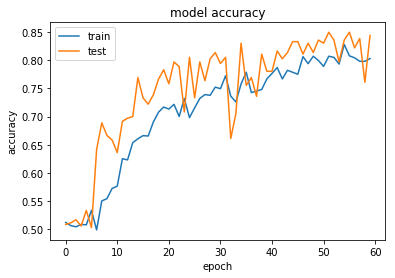

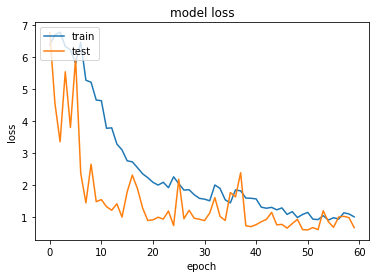

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test the model

In [12]:
# Run the model prediction
y_tested = model.predict(x_test)

# Since the model has a sigmoid function in the last dense layer, outputs are between 0-1. Squash into binary...
decision_boundary = 0.5
y_tested[ y_tested > decision_boundary ] = 1
y_tested[ y_tested <= decision_boundary ] = 0

In [13]:
num_correct = 0
num_total = 0
correctly_predicted = y_tested.reshape(-1) == y_test

for state in correctly_predicted:
    if state == True:
        num_correct += 1
    num_total += 1

accuracy = num_correct/num_total
print("Accuracy on test set: {}%".format(round(accuracy,4)*100))
print("Number of images wrongly predicted: {}".format(len(correctly_predicted[correctly_predicted==False])))

Accuracy on test set: 90.62%
Number of images wrongly predicted: 42


# Save the model

In [14]:
datestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M')
model.save('blurdetector_partialblurrectangular_{}.h5'.format(datestamp))

# Inspect the output

### Show random images with truth/prediction from test set

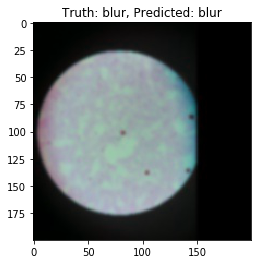

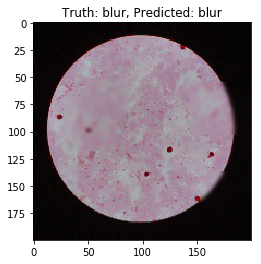

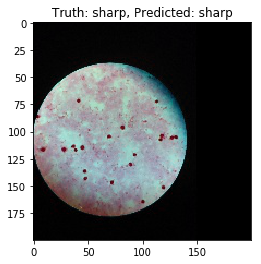

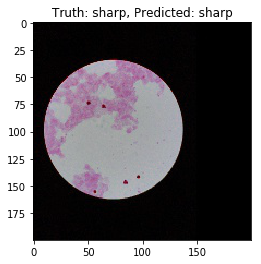

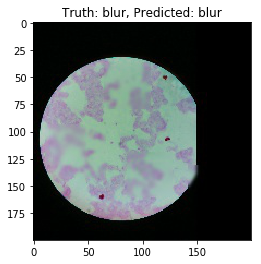

In [15]:
show = 5
labels = {0:'blur', 1:'sharp'}

for i in range(show):
    
    random_draw = random.randint(0,len(y_test))
    
    img = x_test[random_draw]
    truth = int(y_test[random_draw])
    predicted = int(y_tested[random_draw])
    
    plt.title('Truth: {t}, Predicted: {p}'.format(t=labels[truth], p=labels[predicted]))
    plt.imshow(img)
    plt.show()

### Show incorrectly predicted images

Found wrongs: 42


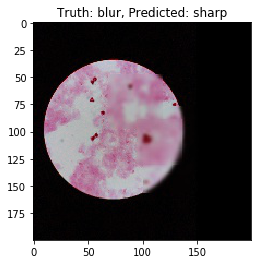

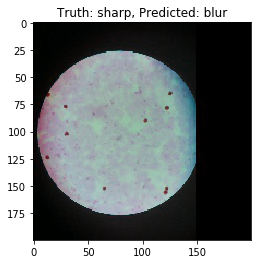

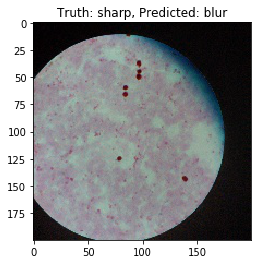

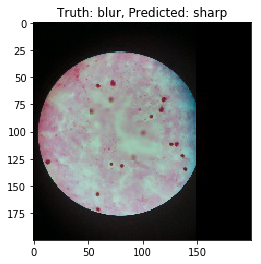

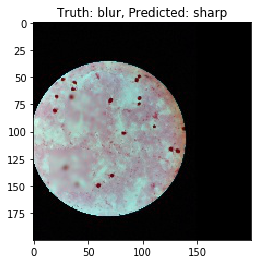

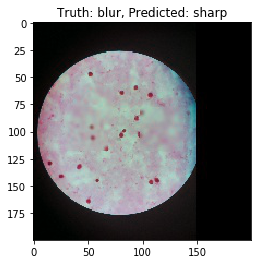

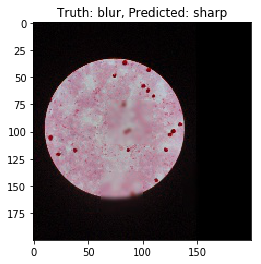

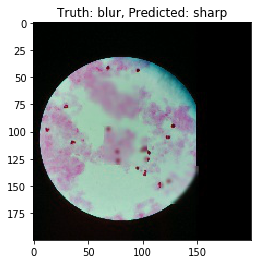

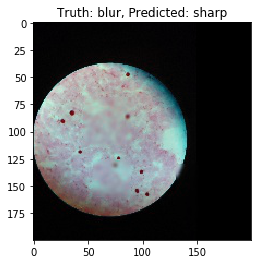

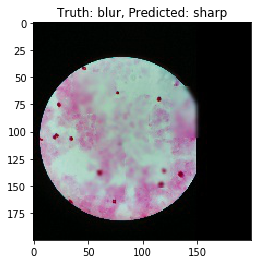

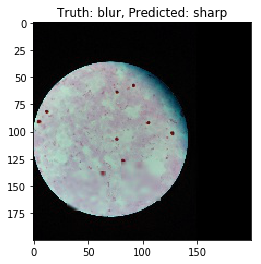

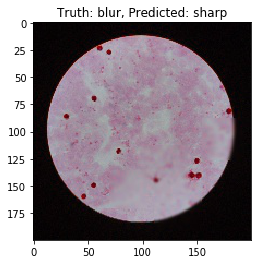

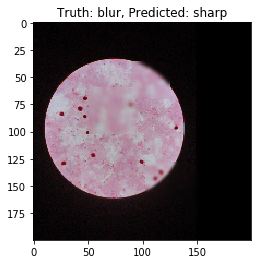

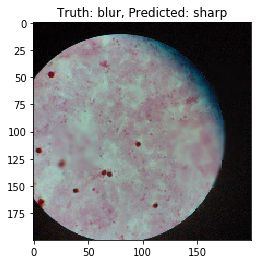

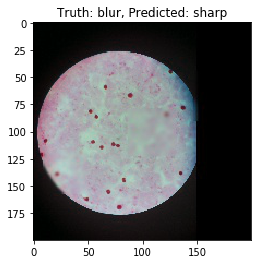

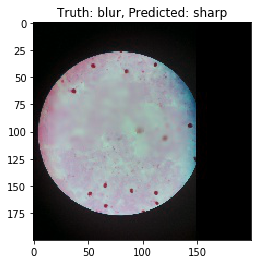

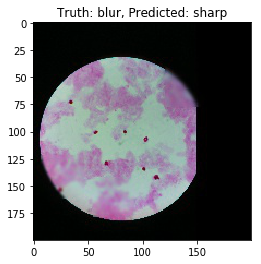

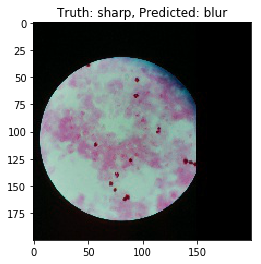

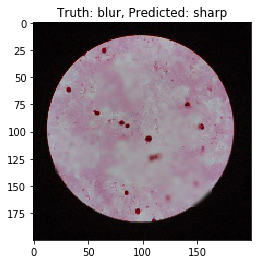

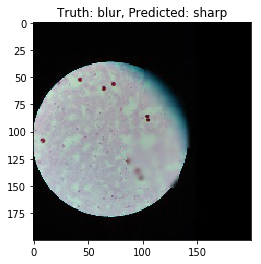

In [16]:
# Find the wrongly predicted ones
wrongs = []
for i in range(len(y_test)):
    if y_test[i] != y_tested[i]:
        wrong = {
            'image': x_test[i],
            'truth': int(y_test[i]),
            'pred': int(y_tested[i]),
        }
        wrongs.append(wrong)
print('Found wrongs: {}'.format(len(wrongs)))

# Plot the wrong predicted ones
for wrong in wrongs[0:min(20,len(wrongs))]:
    plt.title('Truth: {t}, Predicted: {p}'.format(t=labels[wrong['truth']], p=labels[wrong['pred']]))
    plt.imshow(wrong['image'])
    plt.show()